In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import re

bs = 64

# fixes fastai + pandas error
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [3]:
path = "data/"
df = pd.read_csv(f"{path}train.csv", low_memory=False)
df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [4]:
# Add value for sightings to ease creation of validation set
sighting_count = df[df['Id'] != 'new_whale'].Id.value_counts()
sighting_count.name = 'sightings'
df = df.join(sighting_count, on='Id')
df.head()

,Image,Id,sightings
0,00022e1a.jpg,w_e15442c,1.0
1,000466c4.jpg,w_1287fbc,34.0
2,00087b01.jpg,w_da2efe0,11.0
3,001296d5.jpg,w_19e5482,1.0
4,0014cfdf.jpg,w_f22f3e3,2.0


Let's setup the validation set, containing whales with 2 or more sightings

In [5]:
val_func = set(
    df.sample(frac=1)[(df['Id'] != 'new_whale') & (df['sightings'] > 1)].groupby('Id').first().Image
)

C:\Users\matt\Miniconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
len(val_func)

2030

In [7]:
# add 700 new whales to the validation set
val_func = val_func.union(
    set(df[df['Id'] == 'new_whale'].sample(frac=1).Image.values[:700])
)

In [8]:
len(val_func)

2730

In [9]:
func_to_label = { row[1].Image: row[1].Id for row in df.iterrows() }

path_to_func = lambda path: re.search('\w*\.jpg$', path).group(0)

data = (
    ImageItemList
        .from_df(df, path="data/train", cols=['Image'])
        .split_by_valid_func(lambda path: path_to_func(path) in val_func)
        .label_from_func(lambda path: func_to_label[path_to_func(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(
            get_transforms(
                do_flip=False,
                max_zoom=1,
                max_warp=0,
                max_rotate=2
            ),
            size=224,
            resize_method=ResizeMethod.SQUISH
        )
        .databunch(bs=64, path='data')
        .normalize(imagenet_stats)
)

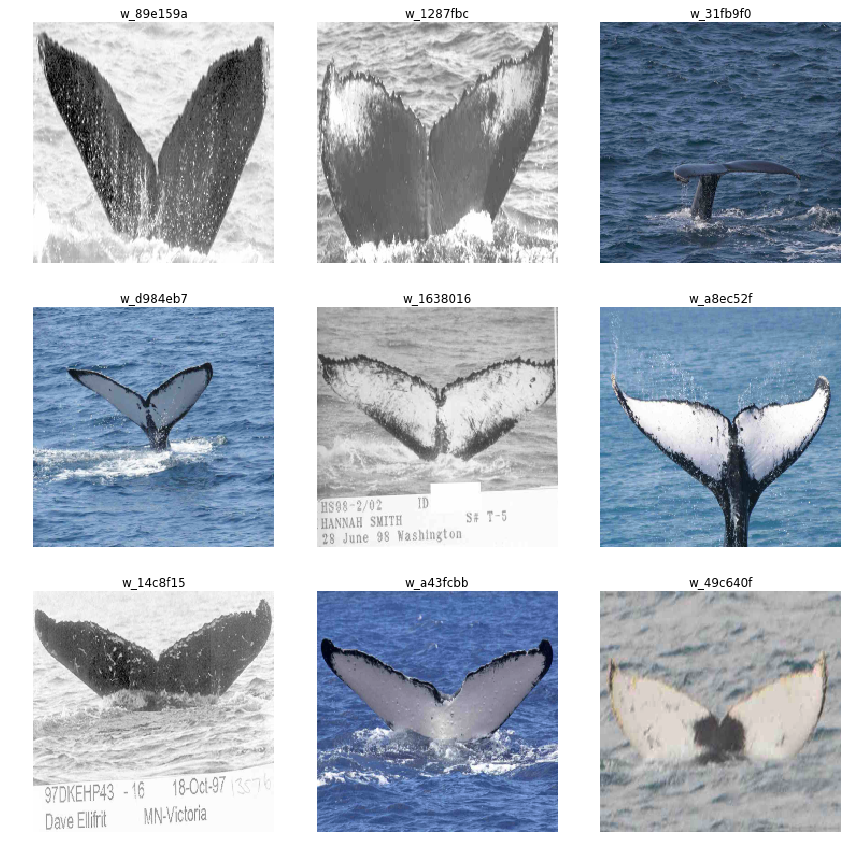

In [22]:
data.show_batch(rows=3)

In [28]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


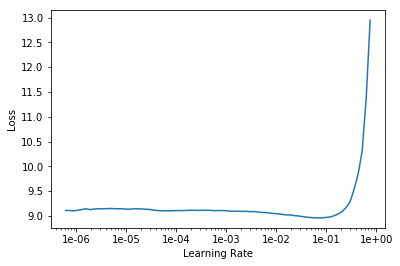

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,8.317499,8.140442,0.976557
2,7.318373,6.987760,0.938095
3,5.300297,6.722931,0.898901


In [31]:
# testing to see if clipping gradients affects outcome
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.clip_grad()
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,8.378992,7.881659,0.976923
2,7.381242,7.025172,0.938462
3,5.476489,6.748377,0.912821


In [32]:
# comparing learning rates
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.clip_grad()
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,8.388803,8.116290,0.984615
2,7.788809,7.424752,0.975458
3,6.698818,6.848151,0.940293


In [34]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, lin_ftrs=[2048])
learn.clip_grad()
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,8.738205,8.474645,0.964103
2,7.355340,6.682563,0.887179
3,3.993858,6.485189,0.850549


In [35]:
learn.fit_one_cycle(7, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,2.437725,6.477189,0.826007
2,3.146882,7.450349,0.840659
3,2.411956,7.498414,0.823077
4,1.275651,7.620636,0.808425
5,0.615460,7.420613,0.792674
6,0.292501,7.089891,0.771795
7,0.136871,7.009471,0.762637


In [36]:
learn.save("resnet34-stage-1")

In [37]:
learn.unfreeze()
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]
learn.fit_one_cycle(10, lrs)
learn.save("resnet34-stage-2")

epoch,train_loss,valid_loss,error_rate
1,0.109069,6.981338,0.761905
2,0.185718,7.112688,0.781319
3,0.366558,7.362401,0.801099
4,0.380385,7.052208,0.795971
5,0.298668,6.964478,0.792674
6,0.221930,6.951269,0.782418
7,0.141723,6.961034,0.783883
8,0.096649,6.950562,0.786447
9,0.055970,6.965552,0.783150
10,0.047430,6.928948,0.785714
